## Transformer-based What-if Scenario Generation (TBWISA)
---

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from source.transformer_forecasting import TransformerForecasting

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

### 1. Load data

...

#### 1.1. Config parameters

In [5]:
# Dataset specific parameters
dataset_name = 'awsce'                              # Dataset name
input_col = 'price'                                 # Dataset column of the independent variable
output_col = 'demand'                               # Dataset column of the dependent variable
result_col = 'revenue'                              # Result column of the objective function
item_id = "item_277"                                # Item ID used in scenario generation
store_id = "store_001"                              # Store ID used in scenario generation
forecast_length = 6                                 # Forecast length for forecasting
penalty_factor = 0.05                               # Reduced penalty factor for larger windows
test_size = 0.2                                     # Test size for train-test split

# Scenario parmaeters
min_window_size = 2                                 # Minimum window size for optimal scenario
max_window_size = 6                                 # Maximum window size for optimal scenario
#price_change_percentages = [-20, -15, -12, -10, -7, -5, 5, 7, 10, 12, 15, 20] # Price change percentages for scenario generation
price_change_percentages = [-15, -10, -5, 0, 5, 10, 15] # Price change percentages for scenario generation
#price_change_percentages = np.arange(-15, 16)      # Price change percentages range for scenario generation

# Transformer parameters
num_layers = 4                                      # range: 2-6
size_layer = 128                                    # range: 64-256
embedded_size = 128                                 # range: 64-256
epochs = 500                                        # range: 200-500 w/ early stopping
dropout_rate = 0.2                                  # range: 0.1-0.3
learning_rate = 0.0001                              # range: 0.0001-0.001
batch_size = 64                                     # 

#### 1.2. Load data

In [6]:
# Load dataset

# AWS Consumer Electronics Dataset
df = pd.read_csv("datasets/aws_ce_dataset.csv", index_col="timestamp", parse_dates=True)

# Filter dataset by item id and store id
data = df[(df["item_id"] == item_id) & (df["store_id"] == store_id)][:-forecast_length]
data_test = df[(df["item_id"] == item_id) & (df["store_id"] == store_id)][-forecast_length-1:]

In [7]:
data

,item_id,store_id,demand,price
timestamp,,,,
2017-10-01,item_277,store_001,288.626646,107.000000
2017-11-01,item_277,store_001,282.965376,107.000000
2017-12-01,item_277,store_001,318.702450,98.588114
2018-01-01,item_277,store_001,302.272854,103.035497
2018-02-01,item_277,store_001,314.649314,102.090009
2018-03-01,item_277,store_001,367.477302,94.016595
2018-04-01,item_277,store_001,256.389981,121.797219
2018-05-01,item_277,store_001,261.051565,121.797219
2018-06-01,item_277,store_001,273.157880,118.443815


In [8]:
data_test

,item_id,store_id,demand,price
timestamp,,,,
2019-03-01,item_277,store_001,282.681705,111.984968
2019-04-01,item_277,store_001,290.815476,111.984968
2019-05-01,item_277,store_001,253.481393,124.210273
2019-06-01,item_277,store_001,254.358372,124.210273
2019-07-01,item_277,store_001,251.350941,124.210273
2019-08-01,item_277,store_001,257.186247,120.341661
2019-09-01,item_277,store_001,249.286224,120.341661


#### 1.3. Data Exploration

Correlation between price and demand time series

Correlation between price and demand: -0.94


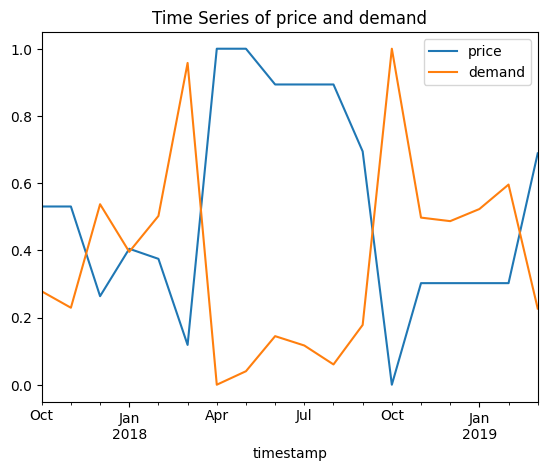

In [9]:
# Plot the time series of input time series and output time series

# Calculate the correlation between the two time series
correlation = data[input_col].corr(data[output_col])
print(f"Correlation between {input_col} and {output_col}: {correlation:.2f}")

filtered_data = data[[input_col, output_col]]
#normalized_df=(filtered_data - filtered_data.mean()) / filtered_data.std()
normalized_df=(filtered_data-filtered_data.min())/(filtered_data.max()-filtered_data.min())

normalized_df.plot(title=f"Time Series of {input_col} and {output_col}")
plt.show()

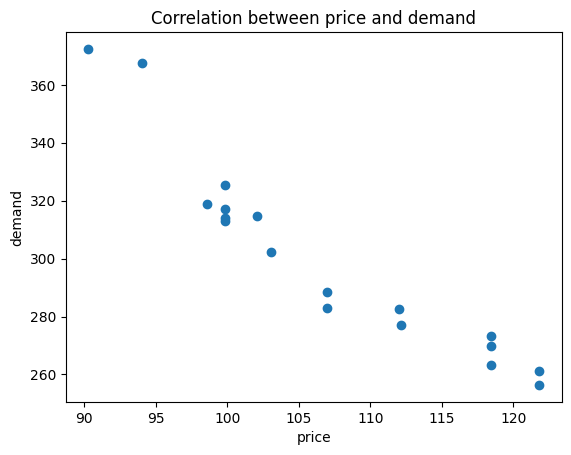

In [10]:
# Scatter plot to visualize correlation
plt.scatter(data[input_col], data[output_col])
plt.title(f'Correlation between {input_col} and {output_col}')
plt.xlabel(input_col)
plt.ylabel(output_col)
plt.show()

---

### 2. Model Construction

#### 2.1. Training the forecasting model

Train the transformer model for input values and output values

*TODO:* add multiple model architectures

In [11]:
model_input = TransformerForecasting(size_layer=size_layer, embedded_size=size_layer, output_size=1, dropout_rate=dropout_rate)
model_output = TransformerForecasting(size_layer=size_layer, embedded_size=size_layer, output_size=1, dropout_rate=dropout_rate)

Initializing Transformer Model
Initializing Transformer Model


In [12]:
# Dataset train-test split

unique_item_ids = df['item_id'].unique()
test_size = int(0.2*len(unique_item_ids))

# complete dataset
train_df = df[df['item_id'].isin(unique_item_ids[:-test_size])]
test_df = df[df['item_id'].isin(unique_item_ids[-test_size:])]

# limited dataset for experimentation
#train_df = df[df['item_id'].isin(unique_item_ids[:50])]
#test_df = df[df['item_id'].isin(unique_item_ids[-5:])]

In [13]:
def train_model(df, model, col, dataset_name="dataset"):
    """Training the transformer model on the training set"""

    train_prices = df[col].dropna().values
    model_file_path = f"trained-models/transformer-{dataset_name}-{col}.pkl"

    if os.path.exists(model_file_path):
        print(f"Trained model already exists -> loading model {model_file_path}")
        with open(model_file_path, 'rb') as file:
            model = pickle.load(file)
    else:
        print(f"Trained model not found -> training a new model {model_file_path}")
        # Train the model
        model.train(train_prices, batch_size, epochs, learning_rate)
        
        # Save the trained model
        os.makedirs(os.path.dirname(model_file_path), exist_ok=True)
        with open(model_file_path, 'wb') as file:
            pickle.dump(model, file)
        print("Model trained and saved successfully.")

    return model

In [14]:
model_input = train_model(train_df, model_input, input_col, dataset_name)
model_output = train_model(train_df, model_output, output_col, dataset_name)

Trained model already exists -> loading model trained-models/transformer-awsce-price.pkl
Trained model already exists -> loading model trained-models/transformer-awsce-demand.pkl


#### 2.2 Baseline forecast

Forecasting the **price** ...

In [15]:
predicted_input = model_input.forecast(data[input_col].values, forecast_length)
baseline_input = pd.DataFrame(data[input_col].iloc[-forecast_length:])
baseline_input[input_col] = predicted_input
baseline_input.index = baseline_input.index + pd.DateOffset(months=forecast_length)
baseline_input.loc[data.index[-1]] = data[input_col][-1]
baseline_input.sort_index(inplace=True)

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/479250326.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_input.loc[data.index[-1]] = data[input_col][-1]


Forecasting the **demand** ...

In [16]:
predicted_output = model_output.forecast(data[output_col].values, forecast_length)
baseline_output = pd.DataFrame(data[output_col].iloc[-forecast_length:])
baseline_output[output_col] = predicted_output
baseline_output.index = baseline_output.index + pd.DateOffset(months=forecast_length)
baseline_output.loc[data.index[-1]] = data[output_col][-1]
baseline_output.sort_index(inplace=True)

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/1769289390.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline_output.loc[data.index[-1]] = data[output_col][-1]


#### 2.3. Scenario generation

**Create** the scenarios ...

In [17]:
# Structural causal elasticity calculation
def calculate_structural_elasticity(input, output):
    regression = LinearRegression()
    log_input = np.log(input).values.reshape(-1, 1)
    log_output = np.log(output).values.reshape(-1, 1)
    regression.fit(log_input, log_output)
    elasticity = regression.coef_[0][0]
    intercept = regression.intercept_[0]
    residuals = log_output - regression.predict(log_input)
    return elasticity, intercept, residuals.flatten()

# Non-linear elasticity adjustment
def non_linear_elasticity(change, base_elasticity):
    return base_elasticity * (1 + 0.5 * change**2)

# Apply randomness with fixed seed for reproducibility
def apply_randomness(demand, scenario_name, randomness_factor=0.01, cap=0.05, seed=42):
    np.random.seed(seed)
    if f'{input_col} change' in scenario_name:
        change = int(scenario_name.split()[2].replace('%', ''))
    else:
        change = 0
    randomness = np.random.normal(loc=0, scale=randomness_factor * abs(change), size=len(demand))
    capped_randomness = np.clip(randomness, -cap, cap)
    stochastic_demand = demand * (1 + capped_randomness)
    return stochastic_demand

# Scenario generation using structural causal inference
def generate_scenarios(data, input_col, output_col, price_change_percentages):
    elasticity, intercept, residuals = calculate_structural_elasticity(data[input_col], data[output_col])
    scenarios_input = {}
    scenarios_output = {}
    for change in price_change_percentages:
        adjusted_input = data[input_col] * (1 + change / 100)
        adjusted_elasticity = non_linear_elasticity(change / 100, elasticity)
        counterfactual_output = np.exp(intercept + adjusted_elasticity * np.log(adjusted_input) + residuals)
        counterfactual_output = apply_randomness(counterfactual_output, f'{input_col} change {change}%', randomness_factor=0.1, cap=0.1)
        scenarios_input[f'{input_col} change {change}%'] = adjusted_input
        scenarios_output[f'{input_col} change {change}%'] = counterfactual_output
    return scenarios_input, scenarios_output

# Forecast application to generated scenarios
def apply_scenarios(data, scenarios, column_name, model, forecast_horizon=30):
    results = {}
    for scenario, value in scenarios.items():
        forecasted_data = model.forecast(value.values, forecast_horizon)
        forecasted_df = pd.DataFrame(data[column_name].iloc[-forecast_horizon:])
        forecasted_df[column_name] = forecasted_data
        forecasted_df.index = forecasted_df.index + pd.DateOffset(months=forecast_horizon)
        forecasted_df.loc[data.index[-1]] = data[column_name][-1]
        forecasted_df.sort_index(inplace=True)
        results[scenario] = forecasted_df
    return results

In [18]:
# Generate scenarios
scenarios_input, scenarios_output = generate_scenarios(data, input_col, output_col, price_change_percentages)

**Forecasting** values of *price* for each scenario ...

In [19]:
# Apply scenarios and forecast
forecasted_input = apply_scenarios(data, scenarios_input, input_col, model=model_input, forecast_horizon=forecast_length)
forecasted_input['Baseline'] = baseline_input
forecasted_input['Actuals'] = data_test[[input_col]]

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/531260018.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/531260018.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/531260018.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

**Forecasting** values of *demand* for each scenario ...

In [20]:
# Apply scenarios and forecast
forecasted_output = apply_scenarios(data, scenarios_output, output_col, model=model_output, forecast_horizon=forecast_length)
forecasted_output['Baseline'] = baseline_output
forecasted_output['Actuals'] = data_test[[output_col]]

/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/531260018.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/531260018.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_df.loc[data.index[-1]] = data[column_name][-1]
/var/folders/8b/dr6bdc0n5pjd47xzpz9x5jy00000gn/T/ipykernel_41532/531260018.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

---

### 3. Experiments

#### 3.1. Evaluating the transformers model for forecasting

*TODO:* add multiple model predictions

In [21]:
def evaluate_model(df, model, col, steps):
    """Uses the trained model to forecast and compute accuracy on the test set"""
    results_list = []

    for (item, store), group in df.groupby(["item_id", "store_id"]):
        print(f"\nForecasting for {item} - {store}")

        # Using col for forecasting
        input_values = group[col].dropna().values

        if len(input_values) < steps:
            print(f"Skipping {item}-{store}: Not enough data.")
            continue

        # Forecast last `steps` days
        predicted_values = model.forecast(input_values[:-steps], steps)

        # Compute error metrics
        actual_values = input_values[-steps:]

        mape = mean_absolute_percentage_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

        results_list.append({
            "item_id": item,
            "store_id": store,
            "MAPE": mape,
            "MAE": mae,
            "RMSE": rmse
        })

        #print(f"Test Set Results for {item} - {store} → MAPE: {mape:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results_list)

    # Compute overall error metrics
    metrics = {
        "Overall_MAPE": results_df["MAPE"].mean(), 
        "Overall_MAE": results_df["MAE"].mean(), 
        "Overall_RMSE": results_df["RMSE"].mean()
    }

    return results_df, metrics

In [22]:
#results_input_df, metrics_input = evaluate_model(test_df, model_input, input_col, forecast_length)
#results_output_df, metrics_output = evaluate_model(test_df, model_output, output_col, forecast_length)

In [23]:
#print("Overall test metrics input:", metrics_input)
#print("Overall test metrics output:", metrics_output)

#### 3.2. Baseline forecast

In [24]:
def visualize_forecast(original_data, forecasted_data, column_name):
    """Visualize the forecast"""
    plt.figure(figsize=(14, 7))
    plt.plot(original_data.index, original_data[column_name], label='Historic ' + column_name, color='blue')
    plt.plot(forecasted_data.index, forecasted_data[column_name], label='Future ' + column_name, color='orange', linestyle='--')
    plt.title(f'Comparison of historic and future {column_name}')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()

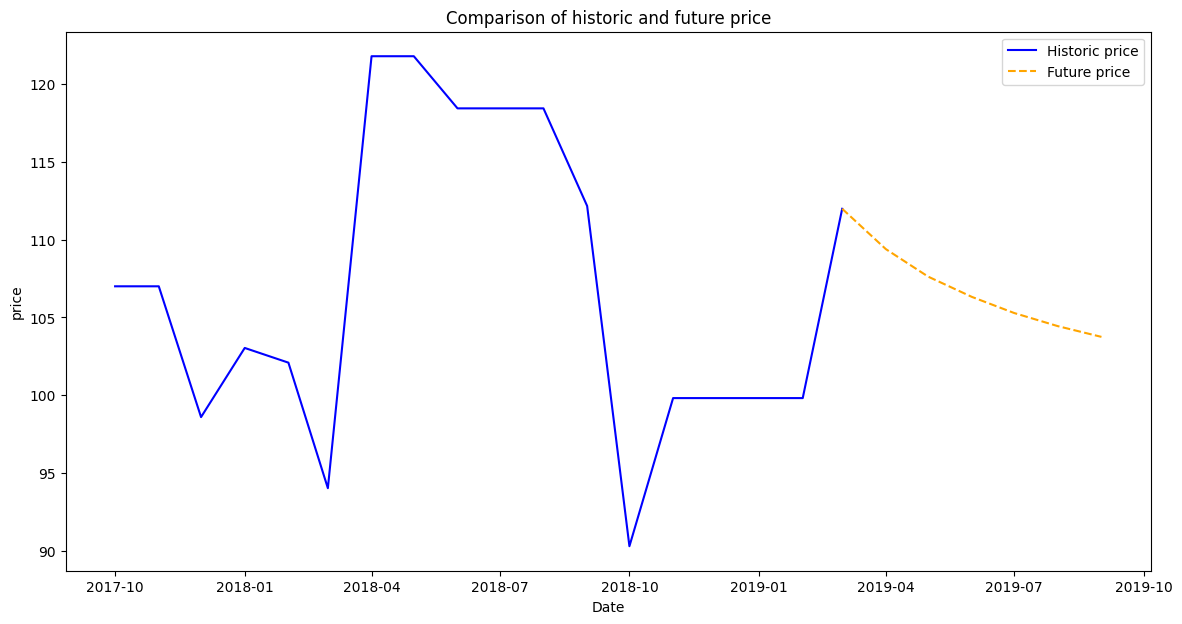

In [25]:
visualize_forecast(data, baseline_input, input_col)

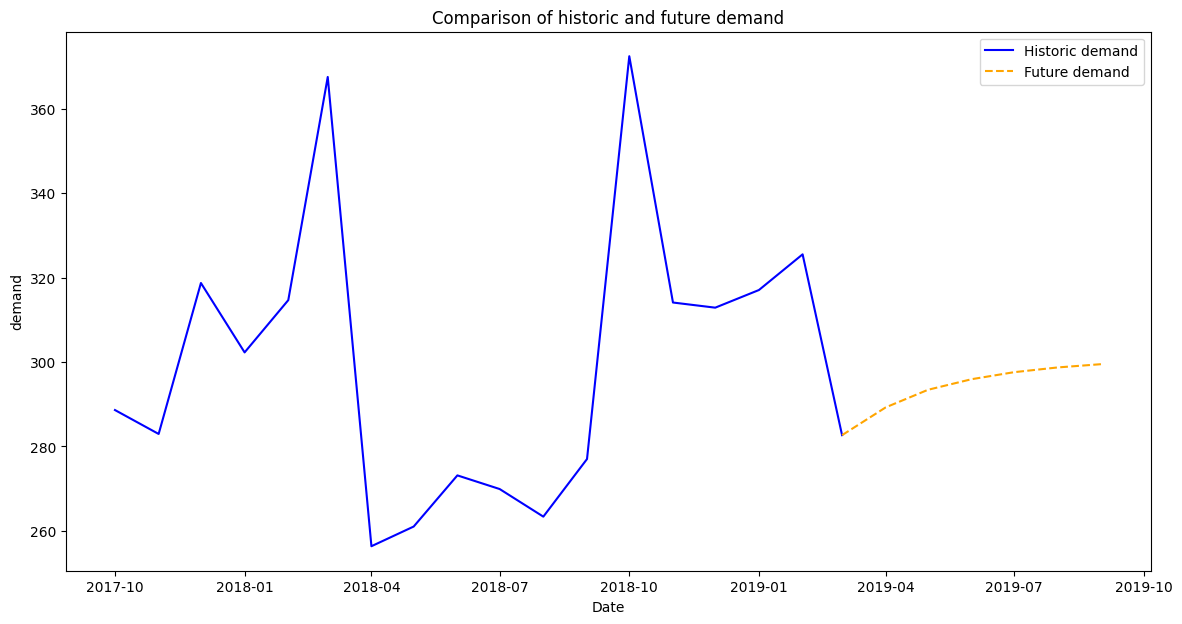

In [26]:
visualize_forecast(data, baseline_output, output_col)

#### 3.3. Scenario visualization

In [27]:
def visualize_scenarios(original_data, forecasted_data, column_name):
    """Visualize the scenarios"""
    plt.figure(figsize=(14, 7))
    plt.plot(original_data.index, original_data, label='Original ' + str(column_name), color='black')

    for scenario, forecast in forecasted_data.items():
        if scenario == "Actuals":
            plt.plot(forecast, label=scenario, color='black')
        else:
            plt.plot(forecast, label=scenario)
    
    plt.title('What-If Scenario Analysis of ' + str(column_name) + ' with structural causal model and elasticity')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.legend()
    plt.show()

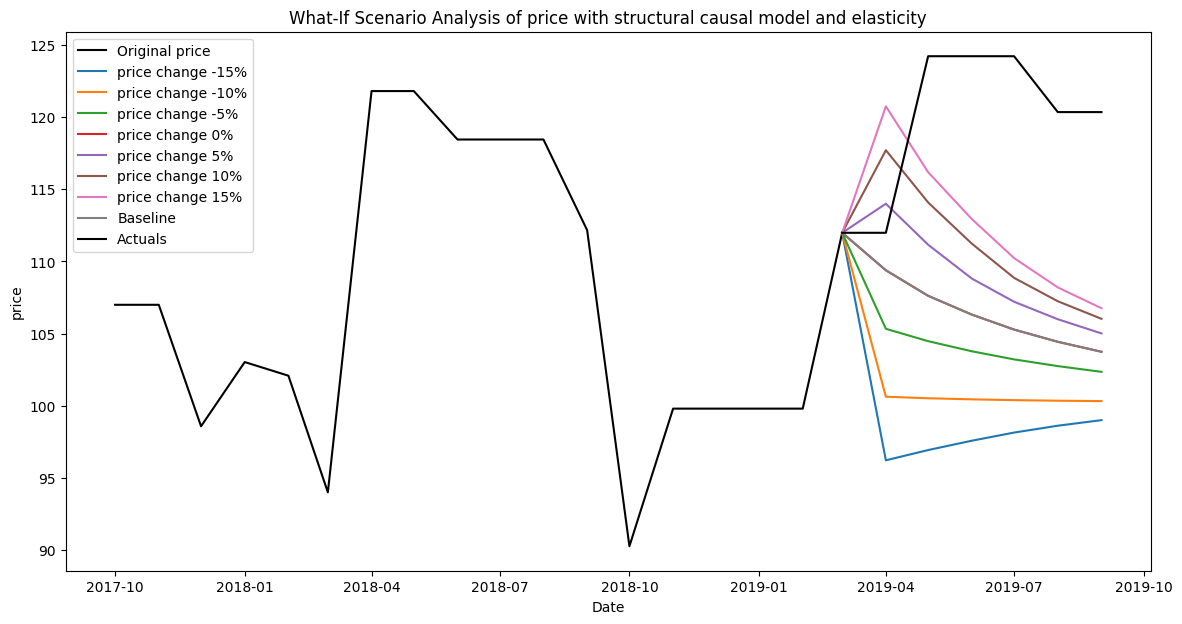

In [28]:
visualize_scenarios(data[input_col], forecasted_input, input_col)

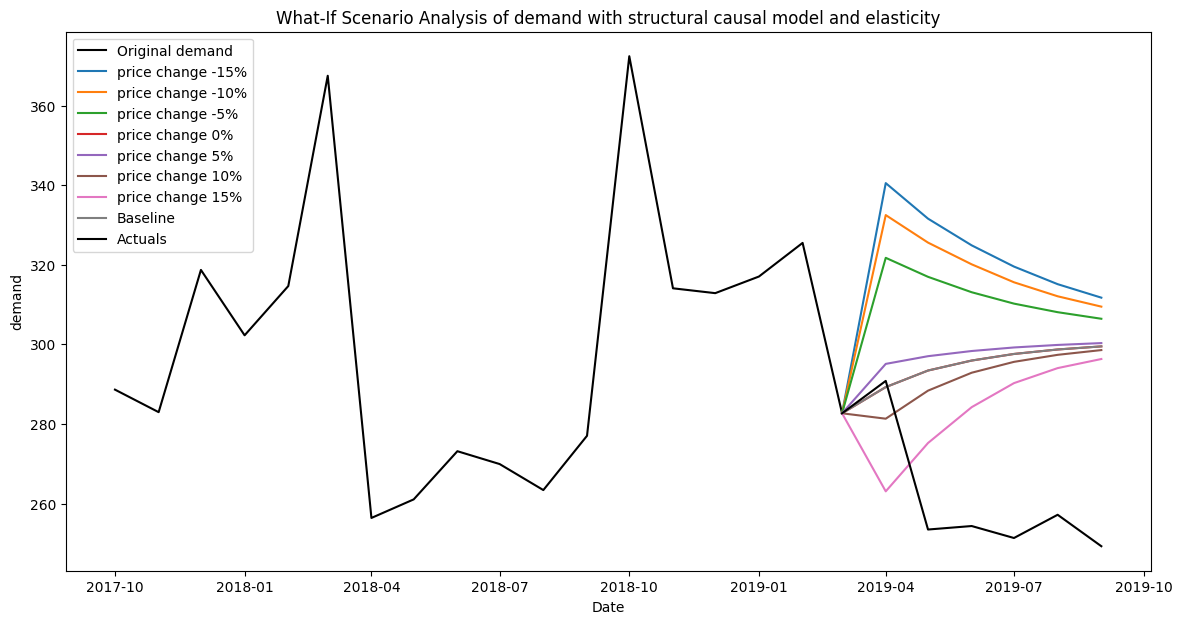

In [29]:
visualize_scenarios(data[output_col], forecasted_output, output_col)

#### 3.4. Generating scenarios of objective

Total **revenue** ...

In [30]:
# Calculate revenue

data[result_col] = data[input_col] * data[output_col]
forecasted_result = {}
total_revenue = {}

for price_scenario, demand_df in forecasted_output.items():
    demand_df = demand_df
    price_df = forecasted_input.get(price_scenario)

    if price_df is not None:
        revenue_df = (demand_df[output_col] * price_df[input_col]).to_frame(name=result_col)
        forecasted_result[price_scenario] = revenue_df
        total_revenue[price_scenario] = revenue_df.sum().values[0]

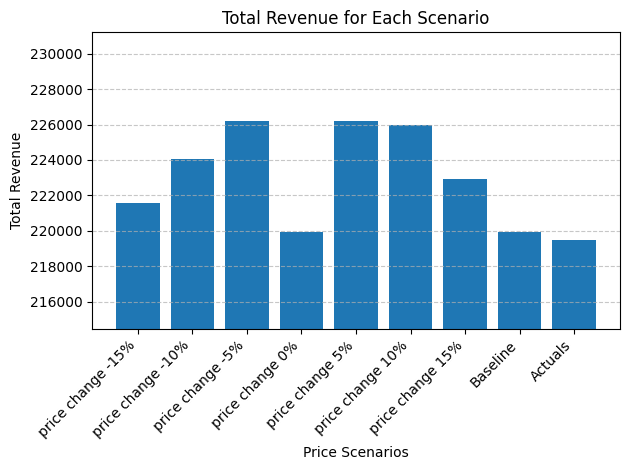

In [31]:
# Plot the total revenue for each scenario

plt.figure()
plt.bar(total_revenue.keys(), total_revenue.values())
plt.ylim([min(total_revenue.values()) - 5000, max(total_revenue.values()) + 5000])
plt.title('Total Revenue for Each Scenario')
plt.xlabel('Price Scenarios')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

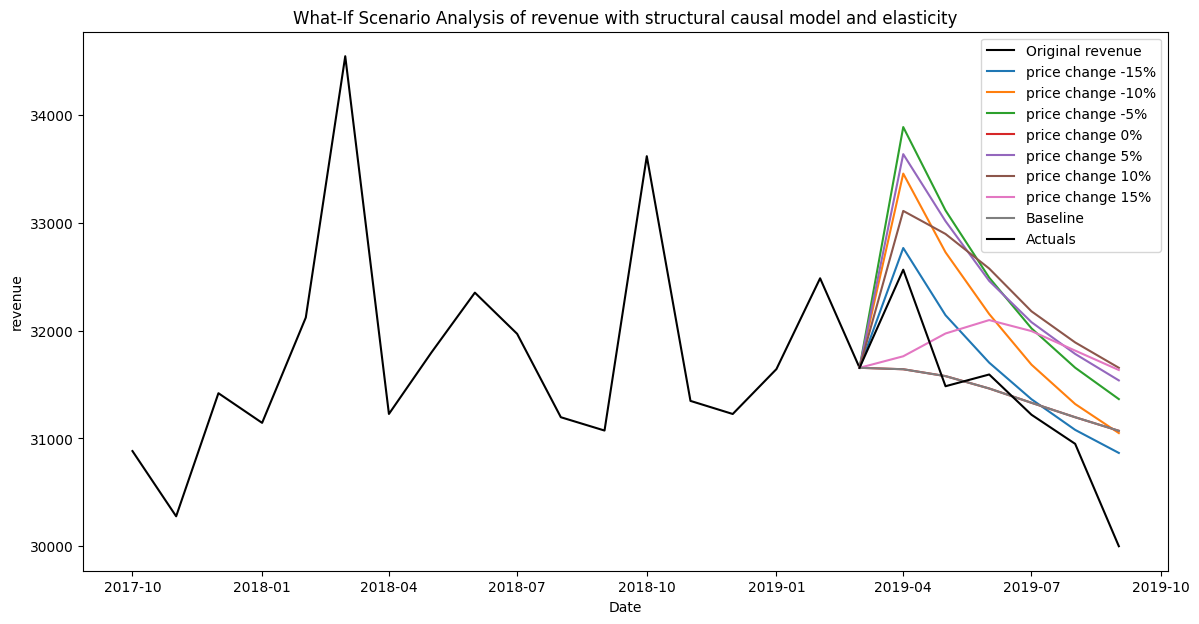

In [32]:
visualize_scenarios(data[result_col], forecasted_result, result_col)

#### 3.5. Evaluating scenarios

In [ ]:
def evaluate_scenarios(actual_demand, forecasted_input, forecasted_output, input_col, output_col, baseline_scenario='Baseline', avg_inventory=100, promo_costs=500):
    """Function to evaluate scenario metrics"""

    metrics = []

    baseline_revenue = (forecasted_input[baseline_scenario][input_col] * forecasted_output[baseline_scenario][output_col]).sum()

    for scenario in forecasted_output.keys():
        forecast_price = forecasted_input[scenario][input_col]
        forecast_demand = forecasted_output[scenario][output_col]
        revenue = (forecast_price * forecast_demand).sum()
        avg_revenue = revenue / len(forecast_demand)
        revenue_uplift = ((revenue - baseline_revenue) / baseline_revenue) * 100

        # Forecast accuracy
        if len(actual_demand) == len(forecast_demand):
            mae = np.mean(np.abs(forecast_demand.values - actual_demand.values))
            rmse = np.sqrt(np.mean((forecast_demand.values - actual_demand.values)**2))
        else:
            mae, rmse = np.nan, np.nan

        # Inventory metrics using average inventory
        units_sold = forecast_demand.sum()
        inventory_turnover = units_sold / avg_inventory
        demand_fulfillment_rate = units_sold / forecast_demand.sum()

        # Business metrics using promotional costs
        roi = ((revenue - promo_costs) / promo_costs) * 100
        compactness = len(forecast_demand) / len(actual_demand)

        scenario_metrics = {
            'Scenario': scenario,
            'Total Revenue': revenue,
            'Avg Revenue per Period': avg_revenue,
            'Revenue Uplift (%)': revenue_uplift,
            'MAE (Demand)': mae,
            'RMSE (Demand)': rmse,
            'Inventory Turnover': inventory_turnover,
            'Demand Fulfillment (%)': demand_fulfillment_rate * 100,
            'ROI (%)': roi,
            'Window Compactness (%)': compactness * 100
        }

        metrics.append(scenario_metrics)

    return pd.DataFrame(metrics)

In [34]:
# Use demand actuals from test set
actual_demand = data_test[output_col]

scenario_results = evaluate_scenarios(actual_demand, forecasted_input, forecasted_output, input_col, output_col)

scenario_results

,Scenario,Total Revenue,Avg Revenue per Period,Revenue Uplift (%),MAE (Demand),RMSE (Demand),Inventory Turnover,Demand Fulfillment (%),ROI (%),Window Compactness (%)
0,price change -15%,221582.249327,31654.607047,0.746099,55.268401,60.293466,22.260392,100.0,44216.449865,100.0
1,price change -10%,224054.360293,32007.765756,1.870086,51.259364,56.083159,21.979759,100.0,44710.872059,100.0
2,price change -5%,226202.716837,32314.673834,2.846872,45.723942,50.369377,21.592279,100.0,45140.543367,100.0
3,price change 0%,219941.269582,31420.181369,0.000000,31.576900,37.242615,20.570932,100.0,43888.253916,100.0
4,price change 5%,226179.675385,32311.382198,2.836396,33.337875,38.848485,20.725255,100.0,45135.935077,100.0
5,price change 10%,225973.656951,32281.950993,2.742726,30.944790,35.440645,20.367886,100.0,45094.731390,100.0
6,price change 15%,222941.438533,31848.776933,1.364077,28.876423,32.111268,19.858090,100.0,44488.287707,100.0
7,Baseline,219941.269582,31420.181369,0.000000,31.576900,37.242615,20.570932,100.0,43888.253916,100.0
8,Actuals,219472.087088,31353.155298,-0.213322,0.000000,0.000000,18.391604,100.0,43794.417418,100.0


In [35]:
## TODO: calculate overall metrics for all items in test_set

#### 3.6. Determining optimal profit window

The optimal profit window generation process involves finding a specific time segment within the forecast period that maximizes profit. Instead of assuming that the entire forecast length is optimal, the algorithm identifies the most profitable subset of the forecast, which could vary in size (from as small as one time step to the full forecast length) ...

In [ ]:
def calculate_score_with_demand(revenue_window, demand_window, penalty_factor, demand_weight):
    """Compute score: revenue minus length penalty, plus reward for low demand"""

    avg_revenue = np.mean(revenue_window)
    window_size = len(revenue_window)
    penalty = penalty_factor * window_size

    # Normalize demand
    max_demand = np.max(demand_window) if np.max(demand_window) > 0 else 1
    avg_demand_norm = np.mean(demand_window) / max_demand

    # Invert demand - higher score for lower demand
    demand_boost = demand_weight * (1 - avg_demand_norm)

    return avg_revenue - penalty + demand_boost

def find_optimal_window_with_demand(forecasted_result, forecasted_output, penalty_factor=0.1, demand_weight=1.0,
                                    min_window_size=2, max_window_size=5):
    """Find the best window for promotion considering both revenue and inverse demand"""

    best = {"scenario": None, "start": None, "end": None, "score": -np.inf}

    for scenario in forecasted_result:
        rev_series = forecasted_result[scenario].values
        demand_series = forecasted_output[scenario].values
        scenario_best_score = -np.inf
        scenario_best_range = (None, None)

        for window_size in range(min_window_size, min(len(rev_series), max_window_size) + 1):
            for start in range(len(rev_series) - window_size + 1):
                rev_window = rev_series[start:start + window_size]
                demand_window = demand_series[start:start + window_size]

                score = calculate_score_with_demand(rev_window, demand_window, penalty_factor, demand_weight)

                if score > scenario_best_score:
                    scenario_best_score = score
                    scenario_best_range = (start, start + window_size - 1)

        if scenario_best_score > best["score"]:
            best.update({
                "scenario": scenario,
                "start": scenario_best_range[0],
                "end": scenario_best_range[1],
                "score": scenario_best_score
            })

    return best

def plot_optimal_window(original_series, forecasted_result, optimal):
    """Plot historical and forecasted revenue and highlight the optimal window"""

    if optimal["scenario"] is None:
        print("No optimal window found.")
        return

    plt.figure(figsize=(14, 7))
    
    # Historical revenue
    plt.plot(original_series.index, original_series.values, label="Historical", color="black", linewidth=2)
    global_min = original_series.min()
    
    # Forecasted revenue for each scenario
    for scenario, series in forecasted_result.items():
        if isinstance(series, pd.DataFrame):
            series = series.iloc[:, 0]
        if scenario == "Actuals":
            plt.plot(series.index, series.values, label=f"Forecast: {scenario}", color='black')
        else:
            plt.plot(series.index, series.values, label=f"Forecast: {scenario}")
        global_min = min(global_min, series.min())
    
    # Extract optimal window details.
    scenario = optimal["scenario"]
    start = optimal["start"]
    end = optimal["end"]
    series = forecasted_result[scenario]
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]
    window_segment = series.iloc[start:end + 1]
    
    # Highlight the optimal window.
    plt.fill_between(window_segment.index, global_min, window_segment.values,
                     color="yellow", alpha=0.3,
                     label=f"Optimal Window: {scenario} ({start}-{end})")
    
    plt.title("Optimal Profit Window")
    plt.xlabel("Time")
    plt.ylabel("Revenue")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

Optimal Scenario: price change -5%
Window: 1 to 2
Score: 33504.04


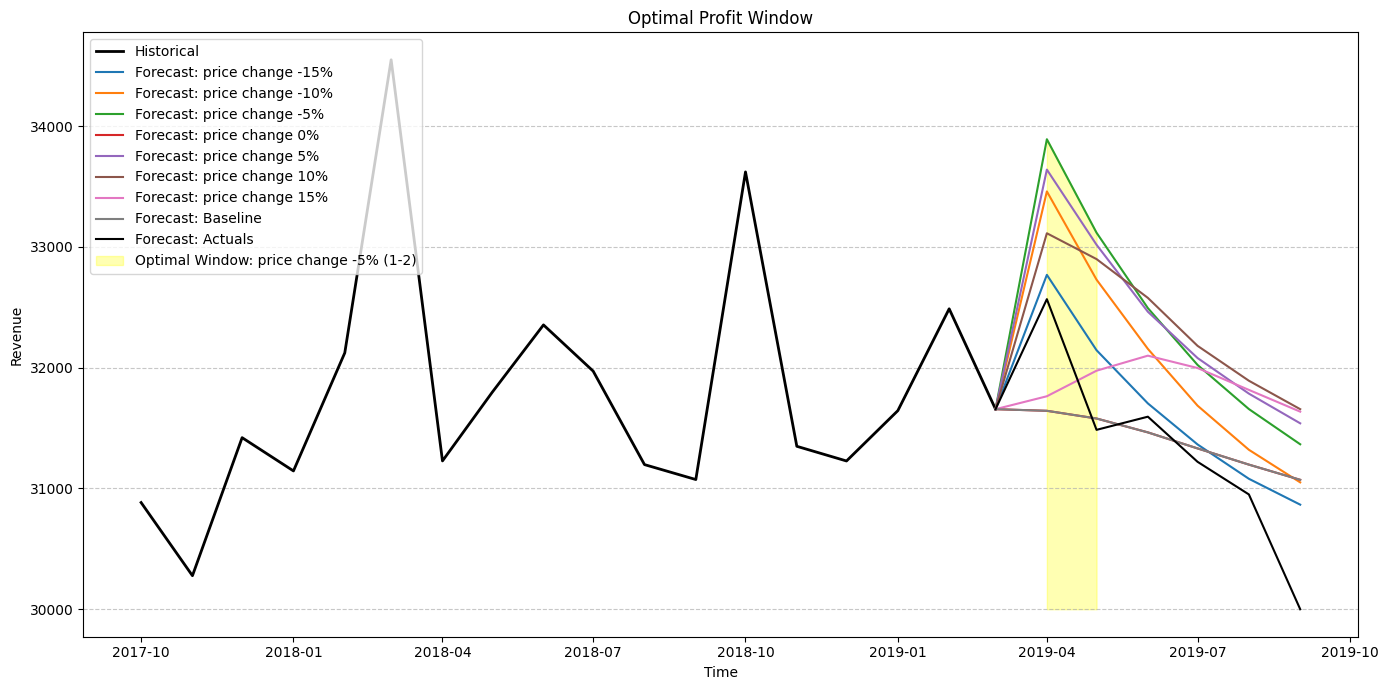

In [40]:
optimal_window = find_optimal_window_with_demand(
    forecasted_result,
    forecasted_output,
    penalty_factor=0.1,
    demand_weight=1.5,
    min_window_size=2,
    max_window_size=5
)

print(f"Optimal Scenario: {optimal_window['scenario']}")
print(f"Window: {optimal_window['start']} to {optimal_window['end']}")
print(f"Score: {optimal_window['score']:.2f}")

plot_optimal_window(data["revenue"], forecasted_result, optimal_window)

In [38]:
## TODO: compare with Amazon what if forecasting